<a href="https://colab.research.google.com/github/steven-mpawulo/KWS_NLP_DeepLearning/blob/main/KWS_NLP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
 
from glob import glob
import librosa
from IPython.display import Audio
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn


In [2]:
fn = []
label = []
for dir_name, _, filenames in os.walk('/content/drive/MyDrive/more_audio_files/latest_keywords'):
  for filename in filenames:
    # print(fn)
    # print(dir_name)
    mylabel = dir_name.split('/')[-1]
    label.append(mylabel.lower())
    myfn = '/content/drive/MyDrive/more_audio_files/'+'latest_keywords/'+mylabel+'/'+filename
    fn.append(myfn)
print('Datset is loaded')

Datset is loaded


In [3]:
df1 = pd.DataFrame({'fn': fn, 'label': label})

In [4]:
newfn = []
newlabel = []
for dir_name, _, filenames in os.walk('/content/drive/MyDrive/nlp_keywords/nlp_keywords'):
  for filename in filenames:
    # print(fn)
    # print(dir_name)
    mylabel = dir_name.split('/')[-1]
    newlabel.append(mylabel.lower())
    myfn = '/content/drive/MyDrive/'+'nlp_keywords/'+'nlp_keywords/'+mylabel+'/'+filename
    newfn.append(myfn)
print('Datset is loaded')

Datset is loaded


In [5]:
df2 = pd.DataFrame({'fn': newfn, 'label': newlabel})
df2 = df2.drop(0, axis=0)

In [6]:
df3 = pd.read_csv('/content/drive/MyDrive/KWS Dataset/Train.csv')


In [7]:
df4 = df3.copy()

In [8]:
df4['fn'] = df4['fn'].apply(lambda x: '/content/drive/MyDrive/audio_files/'+x)

In [9]:
df4

fn        label
0     /content/drive/MyDrive/audio_files/audio_files...      akawuka
1     /content/drive/MyDrive/audio_files/audio_files...       banana
2     /content/drive/MyDrive/audio_files/audio_files...    obulwadde
3     /content/drive/MyDrive/audio_files/audio_files...     nnyaanya
4     /content/drive/MyDrive/audio_files/audio_files...        pampu
...                                                 ...          ...
1104  /content/drive/MyDrive/audio_files/audio_files...      cassava
1105  /content/drive/MyDrive/audio_files/audio_files...   harvesting
1106  /content/drive/MyDrive/audio_files/audio_files...         farm
1107  /content/drive/MyDrive/audio_files/audio_files...  nakavundira
1108  /content/drive/MyDrive/audio_files/audio_files...  nursery bed

[1109 rows x 2 columns]

In [10]:
train = pd.concat([df4,df2,df1])

In [11]:
train

fn          label
0     /content/drive/MyDrive/audio_files/audio_files...        akawuka
1     /content/drive/MyDrive/audio_files/audio_files...         banana
2     /content/drive/MyDrive/audio_files/audio_files...      obulwadde
3     /content/drive/MyDrive/audio_files/audio_files...       nnyaanya
4     /content/drive/MyDrive/audio_files/audio_files...          pampu
...                                                 ...            ...
1735  /content/drive/MyDrive/more_audio_files/latest...  enva endiirwa
1736  /content/drive/MyDrive/more_audio_files/latest...  enva endiirwa
1737  /content/drive/MyDrive/more_audio_files/latest...  enva endiirwa
1738  /content/drive/MyDrive/more_audio_files/latest...  enva endiirwa
1739  /content/drive/MyDrive/more_audio_files/latest...  enva endiirwa

[4709 rows x 2 columns]

In [12]:
train1 = train.copy()

In [13]:
len(train1['label'].unique())

193

In [14]:
train1 = train1.sample(frac=1).reset_index(drop=True)

In [15]:
train1

fn       label
0     /content/drive/MyDrive/more_audio_files/latest...  ebiwojjolo
1     /content/drive/MyDrive/more_audio_files/latest...    omuyembe
2     /content/drive/MyDrive/nlp_keywords/nlp_keywor...     ebikolo
3     /content/drive/MyDrive/more_audio_files/latest...   akasaanyi
4     /content/drive/MyDrive/nlp_keywords/nlp_keywor...     omusiri
...                                                 ...         ...
4704  /content/drive/MyDrive/more_audio_files/latest...     muceere
4705  /content/drive/MyDrive/nlp_keywords/nlp_keywor...    kisaanyi
4706  /content/drive/MyDrive/nlp_keywords/nlp_keywor...    akamonde
4707  /content/drive/MyDrive/nlp_keywords/nlp_keywor...   ekirwadde
4708  /content/drive/MyDrive/nlp_keywords/nlp_keywor...      lusuku

[4709 rows x 2 columns]

In [16]:
class conf:
    sampling_rate = 44100
    duration = 3 # sec
    hop_length = 200*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    padmode = 'constant'
    samples = sampling_rate * duration
def get_default_conf():
    return conf

conf = get_default_conf()

In [17]:
def melspectogram_dB(file_path, cst=3, top_db=80.):
  row_sound, sr = librosa.load(file_path,sr=conf.sampling_rate)
  sound = np.zeros((cst*sr,))
  if row_sound.shape[0] < cst*sr:
    sound[:row_sound.shape[0]] = row_sound[:]
  else:
    sound[:] = row_sound[:cst*sr]

  spec = librosa.feature.melspectrogram(sound, 
                                    sr=conf.sampling_rate,
                                    n_mels=conf.n_mels,
                                    hop_length=conf.hop_length,
                                    n_fft=conf.n_fft,
                                    fmin=conf.fmin,
                                    fmax=conf.fmax)
  spec_db = librosa.power_to_db(spec)
  spec_db = spec_db.astype(np.float32)

  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_img = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  
  return spec_img.astype(np.uint8)
def preprocess_audio(audio_path):
  spec = melspectogram_dB(audio_path)
  spec = spec_to_image(spec)
  return spec

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(128, 221)


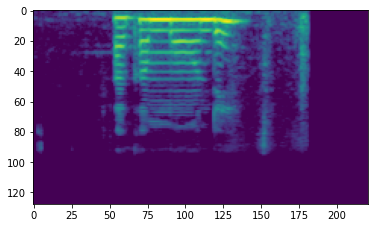

In [18]:
spec = preprocess_audio('/content/drive/MyDrive/nlp_keywords/nlp_keywords/akamonde/6fbfcce2cf21419e97290f9e12934f65_0839dedd71754b1a8cb558292142fe9d.wav')
print(spec.shape)
plt.imshow(spec)

In [19]:
X = train1['fn'].apply(lambda x: preprocess_audio(x))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")

In [20]:
X

0       [[11, 14, 6, 0, 19, 33, 38, 23, 7, 2, 7, 4, 19...
1       [[9, 27, 55, 62, 46, 46, 33, 35, 61, 60, 50, 5...
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4       [[78, 79, 66, 68, 78, 92, 80, 61, 58, 73, 70, ...
                              ...                        
4704    [[78, 82, 74, 73, 72, 59, 65, 62, 41, 42, 64, ...
4705    [[55, 50, 45, 51, 149, 182, 181, 155, 123, 159...
4706    [[48, 42, 39, 25, 20, 37, 49, 62, 54, 15, 8, 2...
4707    [[51, 46, 29, 32, 32, 43, 41, 38, 39, 16, 12, ...
4708    [[49, 48, 37, 44, 39, 33, 46, 63, 74, 83, 87, ...
Name: fn, Length: 4709, dtype: object

In [21]:
X1 = X.copy()

In [22]:
a = X1[0].reshape(128, 221, 1)

In [23]:
a.shape

(128, 221, 1)

In [24]:
X1 = [x.reshape(128, 221, 1) for x in X1]


In [25]:
X2 = X1.copy()

In [26]:
b = tf.convert_to_tensor(X2[0],dtype='float32')

In [27]:
X2 = [tf.convert_to_tensor(x, dtype='float32') for x in X2]

In [28]:
X2 = np.array(X2)

In [29]:
X2.shape

(4709, 128, 221, 1)

In [30]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()


In [31]:
y = enc.fit_transform(train1[['label']])

In [32]:
y = y.toarray()

In [64]:
y.shape

(4709, 193)

In [71]:
import sklearn
from sklearn.model_selection import train_test_split
Xtrain, Xval, ytrain, yval = train_test_split(X2,y, test_size=0.2)

In [72]:
Xtrain.shape

(3767, 128, 221, 1)

In [73]:
Xval.shape

(942, 128, 221, 1)

In [74]:
ytrain.shape

(3767, 193)

In [75]:
yval.shape

(942, 193)

In [82]:
from keras import models
from keras import layers


In [148]:
model = models.Sequential(
    [
        layers.Input(shape=(128, 221, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.7),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(193, activation="softmax"),
    ]
)


model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 126, 219, 32)      320       
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 63, 109, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 61, 107, 64)       18496     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 30, 53, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 28, 51, 128)       73856     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 14, 25, 128)    

In [149]:
from keras.optimizers import Adam
batch_size = 32
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

history = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=epochs)

Epoch 1/50
118/118 [==============================] - 5s 36ms/step - loss: 5.4517 - accuracy: 0.0069
Epoch 2/50
118/118 [==============================] - 4s 36ms/step - loss: 5.1524 - accuracy: 0.0111
Epoch 3/50
118/118 [==============================] - 4s 36ms/step - loss: 5.0982 - accuracy: 0.0109
Epoch 4/50
118/118 [==============================] - 4s 36ms/step - loss: 5.0461 - accuracy: 0.0165
Epoch 5/50
118/118 [==============================] - 4s 36ms/step - loss: 5.0084 - accuracy: 0.0151
Epoch 6/50
118/118 [==============================] - 4s 36ms/step - loss: 4.9480 - accuracy: 0.0236
Epoch 7/50
118/118 [==============================] - 4s 37ms/step - loss: 4.8840 - accuracy: 0.0305
Epoch 8/50
118/118 [==============================] - 4s 37ms/step - loss: 4.7757 - accuracy: 0.0430
Epoch 9/50
118/118 [==============================] - 4s 37ms/step - loss: 4.6524 - accuracy: 0.0473
Epoch 10/50
118/118 [==============================] - 4s 36ms/step - loss: 4.4498 - accura

Text(0, 0.5, 'training loss')

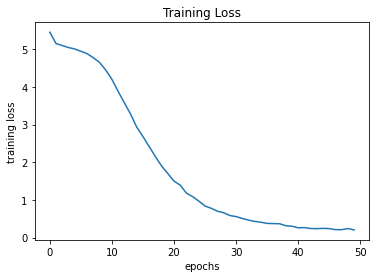

In [150]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('training loss')


Text(0, 0.5, 'training accuracy')

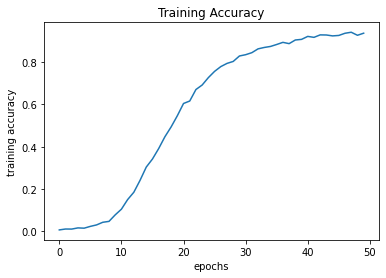

In [151]:
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('training accuracy')

In [89]:
# plt.plot(history.history['val_loss'])
# plt.title('Validation Loss')
# plt.xlabel('epochs')
# plt.ylabel('validation loss')

In [90]:
# plt.plot(history.history['val_accuracy'])
# plt.title('Validation Accuracy')
# plt.xlabel('epochs')
# plt.ylabel('validation accuracy')

In [152]:
model.evaluate(Xval, yval)

30/30 [==============================] - 1s 18ms/step - loss: 3.4562 - accuracy: 0.4437


[3.456190347671509, 0.443736732006073]

In [92]:
pred = model.predict(Xval)

30/30 [==============================] - 1s 15ms/step


In [153]:
m = pred[0]
predictions = []
for prediction in pred:
  values = []
  for x in prediction:
    if (x < 0.7):
      values.append(0)
    else:
      values.append(1)
  predictions.append(values)
predictions


[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,

In [154]:
len(predictions)

942

In [158]:
# predicted value
np.argmax(pred[0])

68

In [157]:
# actual value
np.argmax(yval[0])

68

In [159]:
len(yval)

942

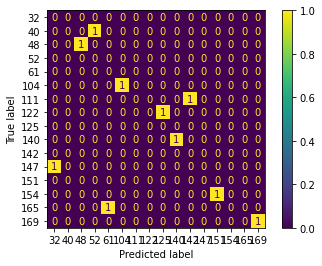

In [161]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(yval[31:41].argmax(axis=1), pred[31:41].argmax(axis=1))
plt.show()
